# Extract Dielectric Function and EELS data

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

######################### Function for: extract_hybridization
from ase.io import read
from ase.neighborlist import NeighborList, natural_cutoffs
from collections import Counter


def extract_hybridization(contcar_path):
    """s
    Extracts %hybridization (sp, sp2, p3) from the CONTCAR file.

    Parameters:
        contcar_path (str): Path to the CONTCAR file.

    Returns:
        dict: A dictionary containing sp, sp2, and sp3 hybridization percentages.
    """
    # Parameters
    cutoff_radius = 1.85  # Cutoff radius for determining neighbors in Angstroms

    # Read the atomic structure from the CONTCAR file
    atoms = read(contcar_path, format='vasp')

    # Use ASE's natural cutoff method with an additional scaling factor
    cutoffs = natural_cutoffs(atoms, mult=1.1)
    neighbor_list = NeighborList(cutoffs, self_interaction=False, bothways=True)
    neighbor_list.update(atoms)

    # Calculate coordination numbers for each atom
    coordination_numbers = [len(neighbor_list.get_neighbors(i)[0]) for i in range(len(atoms))]

    # Filter carbon atoms and count their coordination numbers
    carbon_indices = [i for i, atom in enumerate(atoms) if atom.symbol == 'C']
    carbon_coordination = [coordination_numbers[i] for i in carbon_indices]

    if not carbon_coordination:
        raise ValueError("No carbon atoms found in the structure.")

    # Count sp, sp2, and sp3 hybridized carbon atoms
    hybridization_counts = Counter(carbon_coordination)
    total_carbons = len(carbon_coordination)

    sp_percentage = (hybridization_counts.get(2, 0) / total_carbons) * 100
    sp2_percentage = (hybridization_counts.get(3, 0) / total_carbons) * 100
    sp3_percentage = (hybridization_counts.get(4, 0) / total_carbons) * 100

    return {
        "sp": sp_percentage,
        "sp2": sp2_percentage,
        "sp3": sp3_percentage
    }




######################### Function for: extract_refractive_indices

import numpy as np
import pandas as pd

def extract_refractive_indices(refractive_path, extinction_path):
    """
    Extracts real (n) and imaginary (k) refractive indices vs wavelength.

    Parameters:
        refractive_path (str): Path to the REFRACTIVE.dat file (real refractive index).
        extinction_path (str): Path to the EXTINCTION.dat file (imaginary refractive index).

    Returns:
        dict: A dictionary with wavelengths, averaged real refractive index (n), and imaginary refractive index (k).
    """

    def load_data(file_path, wavelength_min=300, wavelength_max=1200):
        """
        Load refractive or extinction data from a file and process it.

        Parameters:
            file_path (str): Path to the data file.
            wavelength_min (float): Minimum wavelength in nm for filtering.
            wavelength_max (float): Maximum wavelength in nm for filtering.

        Returns:
            pd.DataFrame: Processed DataFrame with wavelength and averaged index values.
        """
        data = np.genfromtxt(file_path, skip_header=2, usecols=(0, 1, 2, 3, 4, 5, 6), filling_values=np.nan)
        columns = ["Energy", "XX", "YY", "ZZ", "XY", "YZ", "XZ"]
        df = pd.DataFrame(data, columns=columns)

        # Convert energy (eV) to wavelength (nm)
        df["Wavelength"] = 1239.84193 / df["Energy"]

        # Filter data based on the wavelength range
#         df = df[(df["Wavelength"] >= wavelength_min) & (df["Wavelength"] <= wavelength_max)]
        
        # Calculate the direction-averaged refractive index (EDITED*)
        df["Average_Index"] = (df["XX"] + df["YY"]) / 2 # + df["ZZ"] + df["XY"] + df["YZ"] + df["XZ"] /6
        
        # In case of Graphite (isotropic material) only average the XX and YY directions:
        if (os.path.basename(os.path.dirname(os.path.dirname(file_path)))=="Graphite"):
            df["Average_Index"] = (df["XX"] + df["YY"]) / 2
        
        return df[["Wavelength", "Average_Index"]]

    # Load and process REFRACTIVE.dat (real refractive index)
    refractive_df = load_data(refractive_path)

    # Load and process EXTINCTION.dat (imaginary refractive index)
    extinction_df = load_data(extinction_path)

    # Combine the real and imaginary parts
    combined_df = pd.merge(refractive_df, extinction_df, on="Wavelength", suffixes=("_n", "_k"))

    # Convert to dictionary for returning
    result = {
        "Wavelength": combined_df["Wavelength"].tolist(),
        "Average_n": combined_df["Average_Index_n"].tolist(),
        "Average_k": combined_df["Average_Index_k"].tolist()
    }

    return result

######################### Function for: calculate_h_c_ratio

def calculate_h_c_ratio(directory_name):
    """
    Calculates the H/C ratio from the folder name.
    Assumes 120 Carbon atoms fixed and extracts number of Hydrogen atoms from the name.
    If no 'H' is mentioned, assumes 0 Hydrogen atoms.

    Args:
        directory_name (str): The name of the directory.

    Returns:
        float: The H/C ratio.
    """
    # Initialize number of hydrogen atoms to 0
    num_h = 0

    # Check if 'H' is mentioned in the directory name
    if 'H' in directory_name:
        try:
            # Extract the number before 'H' and after '_'
            segments = directory_name.split('_')
            for segment in segments:
                if 'H' in segment:
                    num_h = int(segment.replace('H', ''))
                    break
        except ValueError:
            # If parsing fails, assume 0 hydrogen atoms
            num_h = 0

    # Fixed number of Carbon atoms
    num_c = 120

    # Calculate H/C ratio
    h_c_ratio = num_h / num_c

    return h_c_ratio




######################### Function for: compile_data

def compile_data(base_directory):
    """
    Compiles the data for all structures into a DataFrame.
    """
    data = []
    
    for root, dirs, files in os.walk(base_directory):
        # Ensure we are at the top level of the structure folder
        if "7_IP_LOPTICS" in dirs:
            structure_name = os.path.basename(root)
            contcar_path = os.path.join(root, "7_IP_LOPTICS", "CONTCAR")
            refractive_path = os.path.join(root, "7_IP_LOPTICS", "ENERGY_LOSS_SPECTRUM.dat")
            extinction_path = os.path.join(root, "7_IP_LOPTICS", "ENERGY_LOSS_SPECTRUM.dat")
            
            # Extract H/C ratio
            h_c_ratio = calculate_h_c_ratio(structure_name)
            
            # Extract hybridization percentages
            hybridization = extract_hybridization(contcar_path)
            
            # Extract refractive indices
            refractive_indices = extract_refractive_indices(refractive_path, extinction_path)
            
            # Append all information to the data list
            data.append({
                "Structure": structure_name,
                "H/C Ratio": h_c_ratio,
                "sp %": hybridization["sp"],
                "sp2 %": hybridization["sp2"],
                "sp3 %": hybridization["sp3"],
                "Refractive Indices": refractive_indices
            })
    
    # Create a DataFrame from the compiled data
    df = pd.DataFrame(data)
    return df

if __name__ == "__main__":
    base_directory = r"C:\Users\joshi\Desktop\test_run\Relaxed_Optics_Runs_Output\Relaxed_Optics_Runs"
    compiled_data = compile_data(base_directory)
    
    # Save the compiled data to a CSV file for further analysis
    compiled_data.to_csv("compiled_EELS_data.csv", index=False)
    display("compiled_EELS_data.csv Saved!")


'compiled_EELS_data.csv Saved!'

In [37]:
len(compiled_data['Refractive Indices'][0]['Wavelength'])

7999

In [54]:
compiled_data

,Structure,H/C Ratio,sp %,sp2 %,sp3 %,Refractive Indices
0,aC_120H_Run1,1.000,0.000000,34.166667,63.333333,"{'Wavelength': [174625.62394366198, 87932.0517..."
1,aC_120H_Run2,1.000,0.000000,33.333333,63.333333,"{'Wavelength': [174625.62394366198, 86702.2328..."
2,aC_120H_Run3,1.000,0.000000,35.000000,58.333333,"{'Wavelength': [174625.62394366198, 86702.2328..."
3,aC_15H_Run1,0.125,8.333333,64.166667,20.000000,"{'Wavelength': [153066.90493827162, 76533.4524..."
4,aC_15H_Run2,0.125,7.500000,74.166667,13.333333,"{'Wavelength': [153066.90493827162, 76533.4524..."
5,aC_15H_Run3,0.125,7.500000,68.333333,23.333333,"{'Wavelength': [154980.24125, 77008.8155279503..."
6,aC_30H_Run1,0.250,9.166667,59.166667,27.500000,"{'Wavelength': [154980.24125, 77490.120625, 51..."
7,aC_30H_Run2,0.250,1.666667,71.666667,24.166667,"{'Wavelength': [154980.24125, 77977.4798742138..."
8,aC_30H_Run3,0.250,5.000000,61.666667,25.000000,"{'Wavelength': [156942.0164556962, 78471.00822..."
9,aC_60H_Run1,0.500,5.000000,56.666667,35.000000,"{'Wavelength': [161018.43246753246, 80509.2162..."


# Plot the EELS

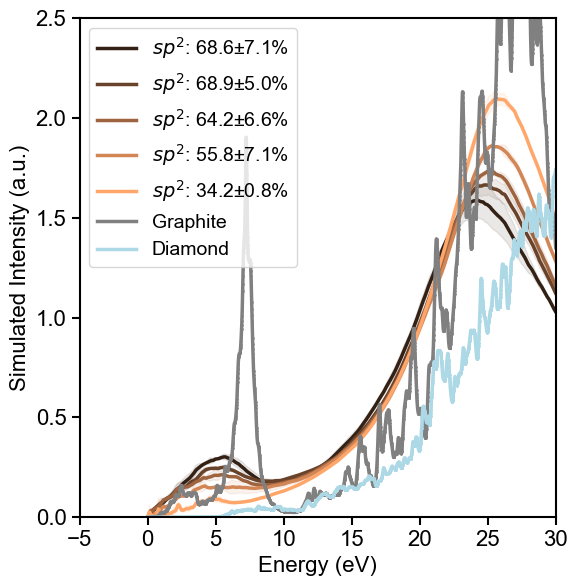

In [75]:

fs = 16
# Set global font and style settings
plt.rcParams.update({
    "font.family": "Arial",
  #  "font.sans-serif": "Helvetica",
})

from matplotlib.lines import Line2D

# Assuming compiled_data is already loaded as a DataFrame
def plot_imaginary_refractive_index(compiled_data):
    
    # Exclude rows where Structure is Graphite or Diamond
    data_for_grouping = compiled_data[~compiled_data['Structure'].isin(['Graphite','Diamond'])]
    
    # Now group by H/C Ratio on the filtered data
    grouped_data = data_for_grouping.groupby('H/C Ratio')    
    
#     # Group by H/C Ratio
#     grouped_data = compiled_data.groupby('H/C Ratio')

    # Define color palette
    colors = sns.color_palette("copper", len(grouped_data))
    # Plotting
    plt.figure(figsize=(6, 6))
    
    # Iterate through groups and assign colors
    for (h_c_ratio, group), color in zip(grouped_data, colors):
        all_wavelengths = [np.array(row['Refractive Indices']['Wavelength']) for _, row in group.iterrows()]
        all_avg_k = [np.array(row['Refractive Indices']['Average_k']) for _, row in group.iterrows()]

        # Ensure wavelengths are consistent by truncating to the minimum length
        min_length = min(len(w) for w in all_wavelengths)
        all_wavelengths = [w[:min_length] for w in all_wavelengths]
        all_avg_k = [k[:min_length] for k in all_avg_k]

        wavelengths = all_wavelengths[0]

        # Calculate mean and std deviation for Average_k
        all_avg_k = np.vstack(all_avg_k)
        mean_k = np.mean(all_avg_k, axis=0)
        std_k = np.std(all_avg_k, axis=0)
        
        # Calculate mean and std deviation for %sp2 hybridization
        mean_sp2_percent = group['sp2 %'].mean()
        std_sp2_percent = group['sp2 %'].std()

        # Plot mean curve with standard deviation shading
        plt.plot(1239.84193/wavelengths, mean_k, label=f"$sp^2$: {mean_sp2_percent:.1f}±{std_sp2_percent:.1f}%", linewidth=2.5, color=color)
        plt.fill_between(1239.84193/wavelengths, mean_k - std_k, mean_k + std_k, alpha=0.1, color=color)
        
        # Find the closest value to 550 nm and add a data point
        idx = np.abs(wavelengths - 550).argmin()
        plt.scatter(wavelengths[idx], mean_k[idx], color=color, edgecolor='black', zorder=10, s=80, label=None)
        
        
    for spine in plt.gca().spines.values():
        spine.set_linewidth(1.5)
    plt.tick_params(axis='both', which='major', length=6, width=1.5, labelsize=fs)  # Major ticks

    plt.xlabel("Energy (eV)", fontsize = fs)
    plt.ylabel("Simulated Intensity (a.u.)", fontsize = fs)
    
    plt.legend(loc="upper left", fontsize=fs-2, ncol=1)
    plt.xlim(-5, 30)
    plt.xticks(fontsize = fs)
    plt.yticks(fontsize = fs)
#     plt.ylim(0, 2.0)
#     plt.axvline(550, color = 'gray', linestyle = '--')
    plt.tight_layout()
    
    # ...
    # [Code for Adding Graphite and Diamond curves]

    # --- Add this block AFTER your main for-loop and BEFORE plt.show() ---
    # Retrieve the rows for Graphite and Diamond
    graphite_row = compiled_data.loc[compiled_data['Structure'] == 'Graphite'].iloc[0]
    diamond_row  = compiled_data.loc[compiled_data['Structure'] == 'Diamond'].iloc[0]

    # Extract Wavelength and Average_k for each
    graphite_wavelengths = graphite_row['Refractive Indices']['Wavelength']
    graphite_k          = graphite_row['Refractive Indices']['Average_k']
    diamond_wavelengths = diamond_row['Refractive Indices']['Wavelength']
    diamond_k           = diamond_row['Refractive Indices']['Average_k']
    
    # Plot Graphite: hexagon marker in gray
    plt.plot(1239.84193/np.array(graphite_wavelengths), graphite_k, 
             marker='h', markersize=1, color='gray', linewidth=2.5, 
             label='Graphite')

    # Plot Diamond: D marker in light blue
    plt.plot(1239.84193/np.array(diamond_wavelengths), diamond_k, 
             marker='D', markersize=1, color='lightblue', linewidth=2.5, 
             label='Diamond')

    # Update legend so these new curves appear
    plt.legend(loc="upper left", fontsize=fs-2, ncol=1)
    plt.xlim(-5, 30)
    plt.ylim(0, 2.5)
    
    # Save
    plt.savefig("Misc_EELS_vs_eV.png", dpi=600)
    plt.show()

# Call the function
plot_imaginary_refractive_index(compiled_data)